In [1]:
###### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import PyTorch
import torch
import torch.nn as nn

# Import TensorLy
import tensorly as tl
from tensorly.cp_tensor import cp_to_tensor
from tensorly import check_random_state

from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

import itertools

C:\Users\tesics\AppData\Local\Temp\ipykernel_9436\2911537438.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
###### Import necessary functions
from DATA_PROs_functions import get_feature_mappings, extract_phenotypes
from DATA_PROs_functions import create_splits

from DATA_PROs_plotting import generate_phenotype_time_evolution

from DATA_PROs_classifier import RF_classifier, plot_rf_feature_importances

from DATA_PROs_model import run_model_with_bias, run_model_without_bias

In [3]:
###### Set random state and seed (same value) 
seed=1221
random_state = 1221 
torch.manual_seed(seed)
rng = check_random_state(random_state)
# device = torch.device("mps")
device = 'cpu'

# Features

In [4]:
static_list=['Prior_med_IFX',
'Prior_med_ADA',
'Prior_med_CZP',
'Prior_med_GOL',
'Prior_med_TOF',
'Prior_med_UPA',
'Prior_med_VDZ',
'Prior_med_UST',
'Current_med_THIO',
'Current_med_MESAL',
'BMI2',
'WeightKG2',
'New_Med_Outcome_yr1',
'age']

In [5]:
lab_list=['Lab_FCP',
'Lab_Hgb',
'Lab_Alb',
'Lab_PLT',
'Lab_Wbc',
'Lab_CRP']

In [6]:
PRO_list=['symptom_bloating',
'symptom_pain',
'symptom_arthritis',
'symptom_urgency',
'symptom_thirsty',
'symptom_tired',
'symptom_weak',
'BM_blood',
'symptom_lackappetite',
'BM_consistancy',
'DA_enjoyment',
'DA_concentrate',
'DA_choirs',
'DA_work',
'DA_travel',
'DA_sleep',
'DA_planning',
'DA_leavinghome',
'DA_sex',
'feeling_alone',
'feeling_angry',
'feeling_depressed',
'feeling_embarrased',
'feeling_frustrated',
'feeling_scared',
'feeling_worried',
'feeling_nocontrol',
'bm_leak',
'bm_mucus']

In [7]:
# Make separate lists for the lab values for each timepoint
lab_list0=[s + '_time_0' for s in lab_list]
lab_listp1=[s + '_time__1' for s in lab_list]
lab_listp2=[s + '_time__2' for s in lab_list]
lab_listp3=[s + '_time__3' for s in lab_list]
lab_lista1=[s + '_time_1' for s in lab_list]
lab_lista2=[s + '_time_2' for s in lab_list]
lab_lista3=[s + '_time_3' for s in lab_list]

# Make separate lists for the symptom scores for each timepoint
PRO_list0=['PRO_' + s + '_Time_0' for s in PRO_list]
PRO_listp1=['PRO_' + s + '_Time_p1' for s in PRO_list]
PRO_listp2=['PRO_' + s + '_Time_p2' for s in PRO_list]
PRO_listp3=['PRO_' + s + '_Time_p3' for s in PRO_list]
PRO_lista1=['PRO_' + s + '_Time_a1' for s in PRO_list]
PRO_lista2=['PRO_' + s + '_Time_a2' for s in PRO_list]
PRO_lista3=['PRO_' + s + '_Time_a3' for s in PRO_list]

In [8]:
# Put all the features together 
feature_list = [lab_list0,lab_listp1,lab_listp2,lab_listp3,lab_lista1,lab_lista2,lab_lista3,
                PRO_list0,PRO_listp1,PRO_listp2,PRO_listp3,PRO_lista1,PRO_lista2,PRO_lista3,
                static_list,['New_Med_Outcome_yr2', 'New_Med_Outcome_yr3']]

feature_list = list(itertools.chain.from_iterable(feature_list))

# Preprocessing

In [9]:
###### Read in data, examine shape, drop majorly empty rows
df = pd.read_excel('DATA_PRO_UC_dataset.xlsx')
df = df[feature_list]

# Encode variables and fill outcomes
df.replace(['not at all', 'a little bit', 'somewhat', 'quite a bit', 'a great deal'],
                        [0, 1, 2, 3, 4], inplace=True)
df.replace(['fail', 'success'],
                        [0, 1], inplace=True)
df['New_Med_Outcome_yr1'] = df['New_Med_Outcome_yr1'].fillna(0)
df['New_Med_Outcome_yr2'] = df['New_Med_Outcome_yr2'].fillna(0)
df['New_Med_Outcome_yr3'] = df['New_Med_Outcome_yr3'].fillna(0)

print(f"Raw data shape is: {df.shape}")
print(f"Raw data fraction of missing values using only desired features is {(df.isna().sum().sum())/(df.shape[0]*df.shape[1])}")
print("Removing patients (rows) that are >= 90% missing values...")
df.dropna(thresh=len(df.columns)*10/100, axis=0, inplace=True)
print(f"Updated fraction of missing values is {(df.isna().sum().sum())/(df.shape[0]*df.shape[1])}")
print(f"Updated data shape is: {df.shape}")

# Set the desired variable lists
print("Setting the desired static, lab, and PRO variables")

# Mean impute for the static variables
df1=df[static_list]
df1=df1.fillna(df1.mean()) # mean impute for static variables

# Set static matrix with imputed values
mat=df1[static_list]

# Set desired outcomes
outcome2=df[['New_Med_Outcome_yr2']]
outcome3=df[['New_Med_Outcome_yr3']]

symptom_data = df[PRO_list0+PRO_listp1+PRO_listp2+PRO_listp3+PRO_lista1+PRO_lista2+PRO_lista3]
symptom_tensor = np.stack((df[PRO_list0],df[PRO_listp1],df[PRO_listp2],df[PRO_listp3],df[PRO_lista1],df[PRO_lista2],df[PRO_lista3]), axis=2)
print(symptom_tensor.shape)

# Calculate the number of missing values
num_nan = np.count_nonzero(np.isnan(symptom_tensor))
total_elements = symptom_tensor.size

# Calculate the percentage of missing values
percentage_nan = (num_nan / total_elements) * 100
print(f"The percentage of missing symptom values is {percentage_nan:.2f}%.")

Raw data shape is: (2545, 261)
Raw data fraction of missing values using only desired features is 0.7715752470850364
Removing patients (rows) that are >= 90% missing values...
Updated fraction of missing values is 0.7565860288845301
Updated data shape is: (2303, 261)
Setting the desired static, lab, and PRO variables
(2303, 29, 7)
The percentage of missing symptom values is 88.30%.


In [10]:
count_of_ones = (outcome2.values == 1).sum()
total_count = len(outcome2.values)  
fraction_of_ones = count_of_ones / total_count

print("outcome 2 fraction positive class: ", fraction_of_ones)

count_of_ones = (outcome3.values == 1).sum()
total_count = len(outcome3.values) 
fraction_of_ones = count_of_ones / total_count
print("outcome 2 fraction positive class: ", fraction_of_ones)

outcome 2 fraction positive class:  0.5379939209726444
outcome 2 fraction positive class:  0.4198871037776813


In [11]:
###### Standardize then noramlize 0,1 for static features
scaler = MinMaxScaler()
symptom_scalar = MinMaxScaler((0,1))

col_means = np.mean(mat, axis=0)
col_std_devs = np.std(mat, axis=0, ddof=0)
mat = (mat - col_means) / col_std_devs
mat = symptom_scalar.fit_transform(mat) 

In [12]:
# Format data using the lab values and symptom data
df2=df[lab_list0+lab_listp1+lab_listp2+lab_listp3+lab_lista1+lab_lista2+lab_lista3+
       PRO_list0+PRO_listp1+PRO_listp2+PRO_listp3+PRO_lista1+PRO_lista2+PRO_lista3]
print(df2.shape)

(2303, 245)


In [13]:
# Make slices of the structured data based on timepoint
tens0=df2[lab_list0+PRO_list0]
tens1=df2[lab_lista1+PRO_lista1]
tens2=df2[lab_lista2+PRO_lista2]
tens3=df2[lab_lista3+PRO_lista3]
tens_1=df2[lab_listp1+PRO_listp1]
tens_2=df2[lab_listp2+PRO_listp2]
tens_3=df2[lab_listp3+PRO_listp3]

In [14]:
###### Standardize and normalize each timepoint
tensor_list = [tens0, tens1, tens2, tens3, tens_1, tens_2, tens_3]

# Original, non-normalized, non-scaled data for later use
original_T = np.stack((tens_3,tens_2,tens_1,tens0,tens1,tens2,tens3), axis=2)

for i in range(len(tensor_list)):
    # Standardize each timepoint matrix
    col_means = np.mean(tensor_list[i], axis=0)
    col_std_devs = np.std(tensor_list[i], axis=0, ddof=0)
    tensor_list[i] = (tensor_list[i] - col_means) / col_std_devs

    # Normalize each timepoint
    tensor_list[i] = scaler.fit_transform(tensor_list[i])

# Normalize each timepoint
tens0=scaler.fit_transform(tensor_list[0])
tens1=scaler.fit_transform(tensor_list[1])
tens2=scaler.fit_transform(tensor_list[2])
tens3=scaler.fit_transform(tensor_list[3])
tens_1=scaler.fit_transform(tensor_list[4])
tens_2=scaler.fit_transform(tensor_list[5])
tens_3=scaler.fit_transform(tensor_list[6])

# Create temporal data tensor (T)
T = np.stack((tens_3,tens_2,tens_1,tens0,tens1,tens2,tens3), axis=2)
T.shape, mat.shape

((2303, 35, 7), (2303, 14))

In [15]:
static_mapping, temporal_mapping = get_feature_mappings(static_list, lab_list, PRO_list)

# Set up model with train and test set

In [16]:
###### Set labels and name data
tl.set_backend('pytorch')
shape = T.shape
Mshape = mat.shape

labels2 = torch.tensor(outcome2.values,dtype=torch.float32).to(device)
labels3 = torch.tensor(outcome3.values,dtype=torch.float32).to(device)
labels = torch.cat([labels2,labels3], axis=1)

tensor = torch.tensor(T, dtype=torch.float32).to(device)
tensor1 = torch.tensor(T, dtype=torch.float32).to(device) # Copy for comparison
Mtensor = torch.tensor(mat, dtype=torch.float32).to(device)

In [17]:
# Split into training, test, and validation set
train_idx, test_idx, val_idx = create_splits(labels2, labels3, device=device, seed=1221)
len(train_idx), len(test_idx), len(val_idx)

(1381, 461, 461)

# Run supervised model, optimizing for rank

In [18]:
###### Run one model and unpack results
relu = nn.ReLU()
results = []

# Uncomment desired funtion below
# ALS WITH BIAS
# result_dict, hyperparameters_dict = run_model_with_bias(tensor, tensor1, Mtensor, 
#               rng=rng, device=device, 
#               train_idx=train_idx, test_idx=test_idx, val_idx=val_idx, labels=labels,
#               rank=28, n_epoch=1400, Lambda=0.7, lr=0.01, 
#               penalty_l1=0.001, penalty_l2 = 0, theta = 0.9, grid=False) 

# ALS WITHOUT BIAS
result_dict, hyperparameters_dict = run_model_without_bias(tensor, tensor1, Mtensor, 
              rng=rng, device=device, 
              train_idx=train_idx, test_idx=test_idx, val_idx=val_idx, labels=labels,
              rank=28, n_epoch=1400, Lambda=0.7, lr=0.01, 
              penalty_l1=0.001, penalty_l2 = 0, theta = 0.9, grid=False)


# Unpack results
MAE_val = result_dict['mae']
RMSE_val = result_dict['rmse']
outcome2_auc = result_dict['outcome2_auc']
outcome3_auc = result_dict['outcome3_auc']
rec_loss = result_dict['rec loss']
plot_vals = result_dict['rec loss plot vals']
factor0 = result_dict['pts_x_rank']
factor1 = result_dict['temporal_phenotypes']
mfactor1 = result_dict['static_phenotypes']
factor2 = result_dict['temporal_x_rank']
weights = result_dict['weights']
patient_bias = result_dict['patient bias']
feature_bias = result_dict['feature bias']
reconstruction = relu(cp_to_tensor((weights, [factor0,factor1,factor2])))

outcome2_f1 = result_dict['outcome2_f1'] 
outcome2_recall = result_dict['outcome2_recall']
outcome2_precision = result_dict['outcome2_precision']
outcome3_f1 = result_dict['outcome3_f1']
outcome3_recall = result_dict['outcome3_recall']
outcome3_precision = result_dict['outcome3_precision']

# Unpack hyperparameters
rank = hyperparameters_dict['rank']
original_rank = hyperparameters_dict['rank'] # For later use
n_epoch = hyperparameters_dict['n_epoch']
lr = hyperparameters_dict['lr']
Lambda = hyperparameters_dict['Lambda'] 
penalty_l1 = hyperparameters_dict['penalty_l1'] 
penalty_l2 = hyperparameters_dict['penalty_l2']
alpha = 0.05

results.append((MAE_val.item(), RMSE_val.item(), outcome2_auc, outcome2_f1, outcome2_precision, outcome2_recall, outcome3_auc, outcome3_f1, outcome3_precision, outcome3_recall))
results_df = pd.DataFrame(results, columns=["MAE", "RMSE","AUC_Outcome2", "F1_outcome2", "Precision_outcome2", "Recall_outcome2","AUC_Outcome3",  "F1_outcome3", "Precision_outcome3", "Recall_outcome3"])
print(results_df)

Starting epoch: 100
Starting epoch: 200
Starting epoch: 300
Starting epoch: 400
Starting epoch: 500
Starting epoch: 600
Starting epoch: 700
Starting epoch: 800
Starting epoch: 900
Starting epoch: 1000
Starting epoch: 1100
Starting epoch: 1200
Starting epoch: 1300
Parameter containing:
tensor([1.0274, 1.0257, 1.0284, 1.0256, 1.0283, 1.0291, 1.0288, 1.0282, 1.0250,
        1.0284, 1.0278, 1.0240, 1.0233, 1.0270, 1.0275, 1.0255, 1.0256, 1.0277,
        1.0274, 1.0270, 1.0249, 1.0296, 1.0290, 1.0277, 1.0290, 1.0292, 1.0276,
        1.0280], requires_grad=True)
torch.float32
        MAE      RMSE  AUC_Outcome2  F1_outcome2  Precision_outcome2  \
0  0.270872  0.372459      0.655639     0.690335            0.675676   

   Recall_outcome2  AUC_Outcome3  F1_outcome3  Precision_outcome3  \
0         0.705645      0.643376      0.61678            0.548387   

   Recall_outcome3  
0         0.704663  


# RF classifier

In [19]:
# The feature importance NAMES are 1-indexed, indices are zero-indexed
important_indices_1, important_indices_2, importances_df_1, importances_df_2 = RF_classifier(factor0, labels, train_idx, val_idx, test_idx, importance_threshold=0.08) 

filename = "./final_phenotype_images/whole_rank_RF_outcomeyr2_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_1, title="", filename=filename)

filename = "./final_phenotype_images/whole_rank_RF_outcomeyr3_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_2, title="", filename=filename)

(1842, 28)
(461, 28)
torch.Size([461, 2])
AUC for yr2 outcome: 0.832
Precision for yr2 outcome: 0.762
Recall for yr2 outcome: 0.827
F1 score for yr2 outcome: 0.793
AUC for yr3 outcome: 0.796
Precision for yr3 outcome: 0.647
Recall for yr3 outcome: 0.637
F1 score for yr3 outcome: 0.642
AUC for yr2 outcome: 0.832
AUC for yr3 outcome: 0.796
\Phenotype importances for yr2 outcome:
       Phenotype  Importance
9   Phenotype 10    0.076621
14  Phenotype 15    0.066625
2    Phenotype 3    0.059516
10  Phenotype 11    0.041621
5    Phenotype 6    0.040226
24  Phenotype 25    0.039078
11  Phenotype 12    0.037692
8    Phenotype 9    0.035810
25  Phenotype 26    0.035783
7    Phenotype 8    0.033892
15  Phenotype 16    0.033535
21  Phenotype 22    0.032938
6    Phenotype 7    0.031871
23  Phenotype 24    0.031644
18  Phenotype 19    0.031513
13  Phenotype 14    0.031072
26  Phenotype 27    0.030749
4    Phenotype 5    0.030720
17  Phenotype 18    0.030643
16  Phenotype 17    0.030559
1    Phenot

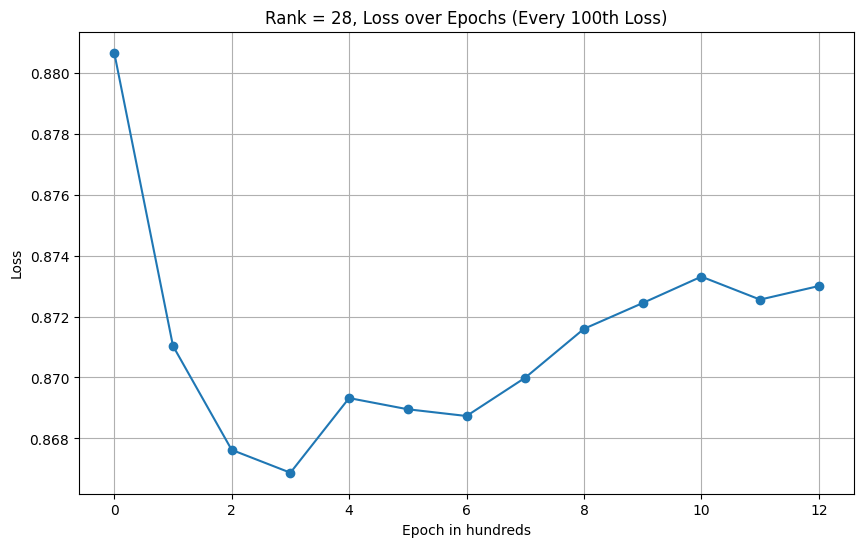

In [20]:
# Plot reconstruction loss across epochs
diagnostic_plot_xvals = np.arange(0, n_epoch, 100)
plt.figure(figsize=(10, 6))
plt.plot(plot_vals, marker='o', linestyle='-')
plt.xlabel('Epoch in hundreds')
plt.ylabel('Loss')
plt.title('Rank = ' + str(rank) + ', Loss over Epochs (Every 100th Loss)')
plt.grid(True)
plt.savefig("./model_diagnostic_images/supervised_model_reconstruction_loss.png")
plt.show()

# Extract phenotypes

In [21]:
temporal_phenotype_dict = extract_phenotypes(factor1, temporal_mapping)
static_phenotype_dict = extract_phenotypes(mfactor1, static_mapping)

In [22]:
# Generate time plot for each phenotype
generate_phenotype_time_evolution(rank, factor2)

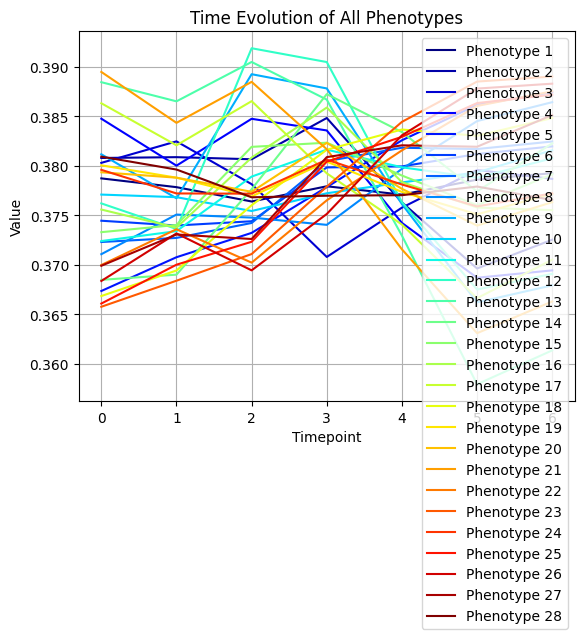

In [23]:
####### Create overlayed time evolution plot
plt.figure()  
colors = plt.cm.jet(np.linspace(0, 1, rank))

for r in range(rank):
    values = factor2[:, r]
    plt.plot(values.detach().numpy(), label=f"Phenotype {r + 1}", color=colors[r])

plt.title("Time Evolution of All Phenotypes")
plt.xlabel("Timepoint")
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig("./model_diagnostic_images/time_evolution_all_phenotypes.png")
plt.show()